In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
import re
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Activation, Flatten, Embedding, LSTM,GRU, Bidirectional, SimpleRNN
from keras.initializers import Constant
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sns
import gensim
import gensim.downloader
from nltk.corpus import brown
import string

In [2]:
import nltk
nltk.download('brown')
nltk.download('punkt')

[nltk_data] Downloading package brown to /home/piyush/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /home/piyush/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
sents = brown.sents()
cleaned_sents = []
for i in sents:
    sentence = []
    for j in i :
        if j not in string.punctuation :
            sentence.append(j.lower())
    cleaned_sents.append(sentence)

In [4]:
model = gensim.models.Word2Vec(cleaned_sents,size=50,window=7,min_count=1)

In [5]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")  

In [6]:
def convert_to_lower(text):
    # return the reviews after convering then to lowercase
    lower_text = text.copy()
    for i in range(len(text)):
        lower_text[i] = text[i].lower()
    return lower_text

In [7]:
def remove_punctuation(text):
    #stop_words = set(stopwords.words('english'))
    without_punctuation_text  = text.copy()
    for i in range(len(text)):
        without_punctuation_text[i] = [w for w in text[i] if w.isalpha()]
    return without_punctuation_text

In [8]:
def perform_tokenization(text):
    tokenize_text = text.copy()
    for i in range(len(text)):
        tokenize_text[i] = nltk.word_tokenize(text[i])
    return tokenize_text

In [9]:
def get_dicts(train):
    reviews = train["reviews"]
    reviews = convert_to_lower(reviews)
    reviews = perform_tokenization(reviews)
    reviews = remove_punctuation(reviews)
    return reviews

In [10]:
review = get_dicts(train)

In [11]:
review = review.to_list()


In [12]:
max_length=50
Embedding_dimension=50

In [13]:
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(review) 
sequences = tokenizer_obj.texts_to_sequences(review)
word_index = tokenizer_obj.word_index
review_pad = pad_sequences(sequences, maxlen=max_length) 

In [14]:
num_words = len(word_index)+1
embedding_matrix = np.zeros ((num_words, Embedding_dimension))
for word, i in word_index.items():
  try:
    embedding_vector = model.wv[word]
    embedding_matrix[i] = embedding_vector
  except:
    continue 

In [15]:
train_rating_list = train['ratings'].to_list()
Y = [str(i-1) for i in train_rating_list]
y_train = tf.keras.utils.to_categorical(Y,num_classes=5)

In [16]:
def preprocess_test(test_reviews):
  reviews = test_reviews
  reviews = convert_to_lower(reviews)
  reviews = perform_tokenization(reviews)
  reviews = remove_punctuation(reviews)
  return reviews

In [17]:
test_review = preprocess_test(test['reviews'])
test_review = test_review.to_list()
sequences_test = tokenizer_obj.texts_to_sequences(test_review)
test_review_pad = pad_sequences(sequences_test, maxlen=max_length) 

In [18]:
y_test = test['ratings']

In [19]:
def predict(model, test_reviews):
        y_pred = model.predict(test_reviews)
        pred1 = []
        for i in range(len(y_pred)):
            pred1.append(np.argmax(y_pred[i])+1)
        return pred1

In [20]:
def report(y_pred,y_test,Model,modelName):
    print("For model = ",modelName)
    Classification_report = classification_report(y_test,y_pred,target_names=['1','2','3','4','5'])
    cm  = confusion_matrix(test['ratings'],y_pred)
    print("Classification Report : \n",Classification_report)
    print("Heat Map :\n")
    sns.heatmap(cm,cmap="Blues",annot=True,fmt='.4g',xticklabels=['1','2','3','4','5'],yticklabels=['1','2','3','4','5'])

In [21]:
def lstmModel():
    model = Sequential()
    embedding_layer = Embedding(num_words,Embedding_dimension,embeddings_initializer=Constant(embedding_matrix), input_length = max_length, trainable=False)
    model.add(embedding_layer)
    model.add(LSTM(units=64, dropout=0.2,recurrent_dropout=0.2))
    model.add (Dense (64, activation='sigmoid'))
    model.add (Dense (5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [22]:
lstm  = lstmModel()
lstm.fit(review_pad, y_train, batch_size=64, epochs=15, validation_split=0.25)


Epoch 1/15
586/586 [==============================] - 34s 58ms/step - loss: 0.9577 - accuracy: 0.6890 - val_loss: 1.0909 - val_accuracy: 0.6016
Epoch 2/15
586/586 [==============================] - 35s 59ms/step - loss: 0.8636 - accuracy: 0.7008 - val_loss: 1.0218 - val_accuracy: 0.6206
Epoch 3/15
586/586 [==============================] - 34s 58ms/step - loss: 0.8337 - accuracy: 0.7084 - val_loss: 1.0069 - val_accuracy: 0.6325
Epoch 4/15
586/586 [==============================] - 34s 58ms/step - loss: 0.8137 - accuracy: 0.7150 - val_loss: 0.9701 - val_accuracy: 0.6385
Epoch 5/15
586/586 [==============================] - 35s 59ms/step - loss: 0.8030 - accuracy: 0.7163 - val_loss: 0.9672 - val_accuracy: 0.6440
Epoch 6/15
586/586 [==============================] - 35s 60ms/step - loss: 0.7861 - accuracy: 0.7217 - val_loss: 0.9728 - val_accuracy: 0.6392
Epoch 7/15
586/586 [==============================] - 35s 59ms/step - loss: 0.7759 - accuracy: 0.7248 - val_loss: 0.9401 - val_accuracy:

In [23]:
y_pred = predict(lstm, test_review_pad)

For model =  LSTM Model
Classification Report : 
               precision    recall  f1-score   support

           1       0.58      0.46      0.51      1271
           2       0.27      0.02      0.04       630
           3       0.35      0.26      0.30       911
           4       0.36      0.17      0.23      1404
           5       0.72      0.95      0.82      5784

    accuracy                           0.66     10000
   macro avg       0.46      0.37      0.38     10000
weighted avg       0.59      0.66      0.60     10000

Heat Map :



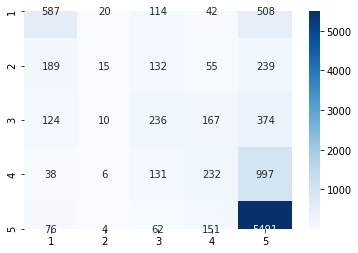

In [24]:
report(y_pred, y_test, lstm,"LSTM Model")

In [25]:
def bilstmModel():
    model = Sequential()
    embedding_layer = Embedding(num_words,Embedding_dimension,embeddings_initializer=Constant(embedding_matrix), input_length = max_length, trainable=False)
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(units=64, dropout=0.2,recurrent_dropout=0.2)))
    model.add (Dense (64, activation='sigmoid'))
    model.add (Dense (5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [26]:
bilstm  = bilstmModel()
bilstm.fit(review_pad, y_train, batch_size=64, epochs=15, validation_split=0.25)

Epoch 1/15
586/586 [==============================] - 34s 59ms/step - loss: 0.9710 - accuracy: 0.6823 - val_loss: 1.0417 - val_accuracy: 0.6140
Epoch 2/15
586/586 [==============================] - 35s 59ms/step - loss: 0.8658 - accuracy: 0.7024 - val_loss: 1.0119 - val_accuracy: 0.6250
Epoch 3/15
586/586 [==============================] - 34s 59ms/step - loss: 0.8379 - accuracy: 0.7084 - val_loss: 0.9837 - val_accuracy: 0.6327
Epoch 4/15
586/586 [==============================] - 35s 60ms/step - loss: 0.8170 - accuracy: 0.7121 - val_loss: 0.9832 - val_accuracy: 0.6363
Epoch 5/15
586/586 [==============================] - 35s 59ms/step - loss: 0.8020 - accuracy: 0.7162 - val_loss: 0.9510 - val_accuracy: 0.6486
Epoch 6/15
586/586 [==============================] - 35s 60ms/step - loss: 0.7918 - accuracy: 0.7194 - val_loss: 0.9510 - val_accuracy: 0.6486
Epoch 7/15
586/586 [==============================] - 35s 60ms/step - loss: 0.7827 - accuracy: 0.7222 - val_loss: 0.9612 - val_accuracy:

For model =  Bi-LSTM Model
Classification Report : 
               precision    recall  f1-score   support

           1       0.58      0.43      0.50      1271
           2       0.25      0.03      0.05       630
           3       0.32      0.35      0.33       911
           4       0.41      0.12      0.19      1404
           5       0.73      0.95      0.82      5784

    accuracy                           0.66     10000
   macro avg       0.46      0.38      0.38     10000
weighted avg       0.60      0.66      0.60     10000

Heat Map :



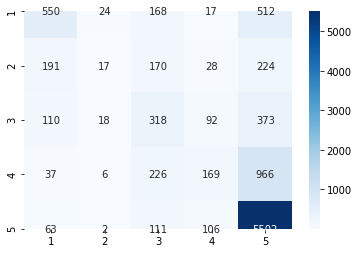

In [27]:
y_pred = predict(bilstm, test_review_pad)
report(y_pred, y_test, bilstm,"Bi-LSTM Model")

In [28]:
def gruModel():
    model = Sequential()
    embedding_layer = Embedding(num_words,Embedding_dimension,embeddings_initializer=Constant(embedding_matrix), input_length = max_length, trainable=False)
    model.add(embedding_layer)
    model.add(GRU(units= 64,dropout=0.2,recurrent_dropout=0.2))
    model.add (Dense (64, activation='sigmoid'))
    model.add (Dense (5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [29]:
gru  = gruModel()
gru.fit(review_pad, y_train, batch_size=64, epochs=15, validation_split=0.25)

Epoch 1/15
586/586 [==============================] - 27s 46ms/step - loss: 1.0020 - accuracy: 0.6777 - val_loss: 1.1556 - val_accuracy: 0.5942
Epoch 2/15
586/586 [==============================] - 30s 51ms/step - loss: 0.8723 - accuracy: 0.7003 - val_loss: 1.0169 - val_accuracy: 0.6224
Epoch 3/15
586/586 [==============================] - 26s 45ms/step - loss: 0.8360 - accuracy: 0.7091 - val_loss: 0.9979 - val_accuracy: 0.6329
Epoch 4/15
586/586 [==============================] - 26s 45ms/step - loss: 0.8156 - accuracy: 0.7142 - val_loss: 0.9479 - val_accuracy: 0.6505
Epoch 5/15
586/586 [==============================] - 26s 45ms/step - loss: 0.7987 - accuracy: 0.7182 - val_loss: 0.9775 - val_accuracy: 0.6430
Epoch 6/15
586/586 [==============================] - 27s 45ms/step - loss: 0.7875 - accuracy: 0.7220 - val_loss: 0.9338 - val_accuracy: 0.6538
Epoch 7/15
586/586 [==============================] - 28s 47ms/step - loss: 0.7776 - accuracy: 0.7226 - val_loss: 0.9412 - val_accuracy:

For model =  GRU Model
Classification Report : 
               precision    recall  f1-score   support

           1       0.53      0.54      0.54      1271
           2       0.22      0.03      0.05       630
           3       0.35      0.22      0.27       911
           4       0.36      0.23      0.28      1404
           5       0.75      0.93      0.83      5784

    accuracy                           0.66     10000
   macro avg       0.44      0.39      0.39     10000
weighted avg       0.60      0.66      0.61     10000

Heat Map :



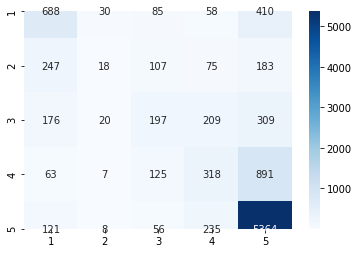

In [30]:
y_pred = predict(gru, test_review_pad)
report(y_pred, y_test, gru,"GRU Model")

In [31]:
def bigruModel():
    model = Sequential()
    embedding_layer = Embedding(num_words,Embedding_dimension,embeddings_initializer=Constant(embedding_matrix), input_length = max_length, trainable=False)
    model.add(embedding_layer)
    model.add(Bidirectional(GRU(units= 64,dropout=0.2,recurrent_dropout=0.2)))
    model.add (Dense (64, activation='sigmoid'))
    model.add (Dense (5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [32]:
bigru  = bigruModel()
bigru.fit(review_pad, y_train, batch_size=64, epochs=15, validation_split=0.25)

Epoch 1/15
586/586 [==============================] - 29s 49ms/step - loss: 0.9976 - accuracy: 0.6801 - val_loss: 1.0964 - val_accuracy: 0.5981
Epoch 2/15
586/586 [==============================] - 29s 50ms/step - loss: 0.8727 - accuracy: 0.7020 - val_loss: 1.0325 - val_accuracy: 0.6239
Epoch 3/15
586/586 [==============================] - 29s 49ms/step - loss: 0.8371 - accuracy: 0.7082 - val_loss: 1.0055 - val_accuracy: 0.6316
Epoch 4/15
586/586 [==============================] - 29s 49ms/step - loss: 0.8191 - accuracy: 0.7118 - val_loss: 1.0061 - val_accuracy: 0.6319
Epoch 5/15
586/586 [==============================] - 31s 53ms/step - loss: 0.8063 - accuracy: 0.7153 - val_loss: 0.9641 - val_accuracy: 0.6438
Epoch 6/15
586/586 [==============================] - 30s 51ms/step - loss: 0.7942 - accuracy: 0.7193 - val_loss: 0.9806 - val_accuracy: 0.6426
Epoch 7/15
586/586 [==============================] - 32s 55ms/step - loss: 0.7818 - accuracy: 0.7227 - val_loss: 0.9713 - val_accuracy:

For model =  Bidirectional GRU Model
Classification Report : 
               precision    recall  f1-score   support

           1       0.62      0.37      0.47      1271
           2       0.24      0.06      0.10       630
           3       0.32      0.26      0.29       911
           4       0.38      0.19      0.25      1404
           5       0.72      0.95      0.82      5784

    accuracy                           0.65     10000
   macro avg       0.46      0.37      0.38     10000
weighted avg       0.59      0.65      0.60     10000

Heat Map :



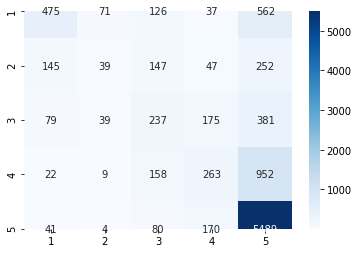

In [33]:
y_pred = predict(bigru, test_review_pad)
report(y_pred, y_test, bigru,"Bidirectional GRU Model")

In [34]:
def rnnModel():
    model = Sequential()
    embedding_layer = Embedding(num_words,Embedding_dimension,embeddings_initializer=Constant(embedding_matrix), input_length = max_length, trainable=False)
    model.add(embedding_layer)
    model.add(SimpleRNN(units= 64,dropout=0.2,recurrent_dropout=0.2))
    model.add (Dense (64, activation='sigmoid'))
    model.add (Dense (5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [36]:
rnn  = rnnModel()
rnn.fit(review_pad, y_train, batch_size=64, epochs=15, validation_split=0.25)


Epoch 1/15
586/586 [==============================] - 11s 18ms/step - loss: 1.0077 - accuracy: 0.6907 - val_loss: 1.1952 - val_accuracy: 0.5833
Epoch 2/15
586/586 [==============================] - 10s 18ms/step - loss: 0.9834 - accuracy: 0.6907 - val_loss: 1.2787 - val_accuracy: 0.5833
Epoch 3/15
586/586 [==============================] - 11s 19ms/step - loss: 0.9653 - accuracy: 0.6908 - val_loss: 1.2456 - val_accuracy: 0.5833
Epoch 4/15
586/586 [==============================] - 12s 21ms/step - loss: 0.9586 - accuracy: 0.6906 - val_loss: 1.1856 - val_accuracy: 0.5833
Epoch 5/15
586/586 [==============================] - 11s 18ms/step - loss: 0.9754 - accuracy: 0.6905 - val_loss: 1.2139 - val_accuracy: 0.5833
Epoch 6/15
586/586 [==============================] - 10s 18ms/step - loss: 0.9740 - accuracy: 0.6909 - val_loss: 1.2576 - val_accuracy: 0.5853
Epoch 7/15
586/586 [==============================] - 11s 18ms/step - loss: 0.9608 - accuracy: 0.6907 - val_loss: 1.1869 - val_accuracy:

For model =  RNN Model
Classification Report : 
               precision    recall  f1-score   support

           1       0.47      0.05      0.10      1271
           2       0.00      0.00      0.00       630
           3       0.00      0.00      0.00       911
           4       0.00      0.00      0.00      1404
           5       0.58      1.00      0.74      5784

    accuracy                           0.58     10000
   macro avg       0.21      0.21      0.17     10000
weighted avg       0.40      0.58      0.44     10000

Heat Map :



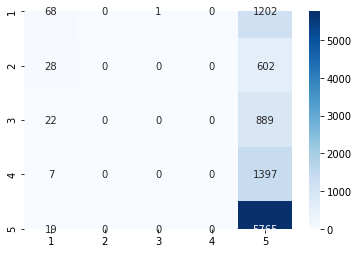

In [37]:
y_pred = predict(rnn, test_review_pad)
report(y_pred, y_test, rnn,"RNN Model")